### Importing required libraries

In [2]:
%matplotlib inline

from ipywidgets import FloatProgress
from IPython.display import display
from ipywidgets import *

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats
from sklearn import cross_validation
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.grid_search import GridSearchCV

### Utilities 

In [4]:
# Regression plot showing predicted gF scores vs original gF scores
def regression_plot(x,y,n,title):

    # fit a curve to the data using a least squares 1st order polynomial fit
    z = np.polyfit(x,y,1)

    p = np.poly1d(z)
    fit = p(x)

    # get the coordinates for the fit curve
    c_x = [np.min(x),np.max(x)]
    c_y = p(c_x)

    # predict y values of origional data using the fit
    p_y = z[0] * x + z[1]

    # calculate the y-error (residuals)
    y_err = y - p_y

    # create series of new test x-values to predict for
    p_x = np.arange(np.min(x),np.max(x)+1,1)

    # now calculate confidence intervals for new test x-series
    mean_x = np.mean(x)         # mean of x
    DF = n - z.size                            # degrees of freedom
    t = stats.t.ppf(0.95,DF)           # used for CI and PI bands
    s_err = np.sum(np.power(y_err,2))   # sum of the squares of the residuals

    #confs = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((p_x-mean_x),2)/((np.sum(np.power(x,2)))-n*(np.power(mean_x,2))))))
    confs = t * np.sqrt((s_err/(n-2)) * (1.0/n + (np.power((p_x-mean_x),2)/(np.sum(np.power(x - mean_x,2))))))
    # now predict y based on test x-values
    p_y = z[0]*p_x+z[1]

    # get lower and upper confidence limits based on predicted y and confidence intervals
    lower = p_y - abs(confs)
    upper = p_y + abs(confs)

    # set-up the plot
    plt.subplots(figsize=(8,8))
    plt.axes().set_aspect('equal')
    plt.xlabel('Original score')
    plt.ylabel('Predicted score')
    plt.title(title)

    # plot sample data
    plt.plot(x,y,'bo')

    # plot line of best fit
    plt.plot(c_x,c_y,'r-',label='Regression line')

    # plot confidence limits
    plt.plot(p_x,lower,'b--',label='Lower confidence limit (95%)')
    plt.plot(p_x,upper,'b--',label='Upper confidence limit (95%)')

    # set coordinate limits
    plt.xlim(4,25)
    plt.ylim(5,25)

    # configure legend
    plt.legend(loc=0)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    plt.setp(ltext, fontsize=10)

    # add text
    rho,p = stats.pearsonr(np.ravel(y),x)
    s = 'r={:0.2f}\np={:1.4f}'.format(rho,p)
    plt.text(20, 7, s, fontsize=12)

    # show the plot
    plt.show()
    

### Importing data

In [4]:
# finn's data set 
data = sio.loadmat('rfMRI_REST1_HCP_Q2')
gF = np.ravel(data['PMAT24_A_CR'])
n_subj = len(gF)
print('No. of subjects:',n_subj)

No. of subjects: 115


In [17]:
# extended data set
data = sio.loadmat('rfMRI_REST1_HCP_Q2')
gF = np.ravel(data['PMAT24_A_CR'])
data2 = sio.loadmat('rfMRI_REST1_HCP_S500.mat')
gF2 = np.ravel(data2['PMAT24_A_CR'])
data_ext = np.concatenate((data['rest_1_mat'],data2['rest_1_mat']),axis=2)
gF = np.concatenate((gF,gF2))
n_subj = len(gF)
print('No. of subjects:',n_subj)

No. of subjects: 435


In [5]:
# improved preprocessing
#data = sio.loadmat('improved_preproc/rfMRI_REST1_HCP_Q2.mat')
data = sio.loadmat('improved_preproc/rfMRI_REST2_HCP_Q2.mat')
gF = np.ravel(data['PMAT24_A_CR'])
n_subj = len(gF)

### gF score distribution

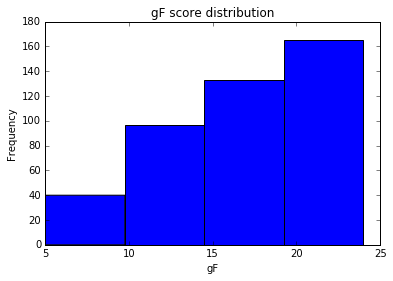

4

In [18]:
# gF score distribution 
def plot_hist(n_bins):
    plt.hist(gF, bins=n_bins)
    plt.title("gF score distribution")
    plt.xlabel("gF")
    plt.ylabel("Frequency")
    plt.show()
    return n_bins
    
interact(plot_hist, n_bins=(4,15,1)) 



In [19]:
# needed for stratified k-fold
n_bins = 4
hist, bin_limits = np.histogram(gF, n_bins)
bins = np.digitize(gF, bin_limits[:-1])
print(bin_limits)

[  5.     9.75  14.5   19.25  24.  ]


### Building of input matrix
Starting from the connectivity matrices of each subject a #subjects x #edges matrix is built selecting for each subject the upper triangular matrix of the connectivity matrix (without the diagonal).

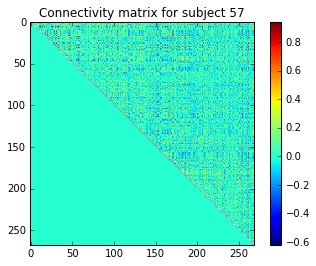

In [6]:
# choose dataset
#conn_mats = data['rest_1_mat']
conn_mats = data['rest_2_mat']
#conn_mats = data_ext

# build matrix n_subjects x n_edges
n_parcels = conn_mats.shape[0]
triu_idx = np.triu_indices(n_parcels,1)
n_edges = len(triu_idx[1]);

def plt_conn(subject):
    plt.imshow(np.triu(conn_mats[:,:,subject-1]))
    plt.colorbar()
    plt.title('Connectivity matrix for subject '+str(subject))

interact(plt_conn, subject=(1,n_subj),continuous_update=False)    
    
edges = np.zeros([n_subj,n_edges])

for subject in range(conn_mats.shape[-1]):
    edges[subject,] = conn_mats[:,:,subject][triu_idx]

### Nested cross validation
An inner  cross validation loop in used to select the best parameters for a linear regression model based on elastic net. The generalization ability of the model is assessed with an outer leave-one-out cross validation loop.

### Test 1: SVR and RFE
Nested cross validation is used to select the best parameters for linear Support Vector Regression (SVR) in combination with Recursive Feature Elimination (RFE). The generalization ability of the model is assessed on the test set.

In [7]:
import warnings
warnings.simplefilter(action = "ignore", category = DeprecationWarning)

# params for SVR
param_grid = [{'C': val} for val in np.logspace(-6,0,10)]

# params for stratified k-fold
k=5
n_bins_cv = 5

svr = SVR(kernel='linear')

selector = RFECV(svr, step=round(0.10*edges.shape[1]), cv=5) #5-fold NOT stratified

# Test with all edges and parameter selection by cross validation
k=5
n_bins_cv = 4
loo = cross_validation.LeaveOneOut(n_subj)
errors = np.zeros([n_subj,1])
predictions = np.zeros([n_subj,1])
i=0
f = FloatProgress(min=0, max=n_subj)
display(f)
for train_index, test_index in loo:
    X_train, X_test, y_train, y_test = edges[train_index,], edges[test_index,],gF[train_index],gF[test_index]
    hist_cv, bin_limits_cv = np.histogram(y_train, n_bins_cv)
    bins_cv = np.digitize(y_train, bin_limits_cv[:-1])
    grids = GridSearchCV(selector, {'estimator_params': param_grid}, 
    cv = cross_validation.StratifiedKFold(bins_cv,k), n_jobs=-1)
    grids.fit(X_train,y_train)
    predictions[i] = grids.predict(X_test)
    errors[i] = abs(predictions[i]-gF[test_index])
    i+=1
    f.value += 1


In [10]:
preds_1 = predictions

In [10]:
preds_2 = predictions

In [9]:
preds_3 = predictions

In [8]:
preds_4 = predictions

In [12]:
print(selector.get_params())

{'estimator': SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False), 'estimator_params': None, 'estimator__C': 1.0, 'estimator__epsilon': 0.1, 'estimator__max_iter': -1, 'estimator__kernel': 'linear', 'estimator__coef0': 0.0, 'estimator__gamma': 'auto', 'cv': 5, 'scoring': None, 'estimator__degree': 3, 'verbose': True, 'step': 3578, 'estimator__cache_size': 200, 'estimator__tol': 0.001, 'estimator__verbose': False, 'estimator__shrinking': True}


### Results on Finn's dataset

In [12]:
print(np.transpose(preds_1))

[[ 15.25304364  17.42051257  16.4316923   20.76306281  15.91685368
   19.97293657  16.16532657  17.89019459  15.62347328  16.97829505
   18.12234458  19.55313499  17.21680783  18.55298249  17.33655149
   17.12482074  19.09656218  17.34680732  18.06110992  18.17551642
   18.74546721  18.12854451  19.03127699  18.89086435  18.17218909
   16.08466077  19.40278481  19.98844842  14.80917219  18.60456555
   19.42318708  17.80201032  16.41188449  17.95530049  17.29005562
   18.99592418  17.75011474  16.07610743  16.22656976  15.76930759
   18.60733407  18.11134396  12.90150011  14.76056147  16.68064267
   17.7457784   17.3247689   16.62571662  19.72993064  17.09104014
   17.70461993  16.55389362  17.17778352  14.90579564  16.50354156
   19.06418017  15.24760658  18.57889894  16.37809925  15.62823398
   15.38566111  17.23969373  16.18803487  19.61232764  14.62824422
   16.14298115  17.98385295  15.83352233  17.21636366  14.7773692
   17.35782919  18.13812504  19.6233926   18.3014056   16.48024

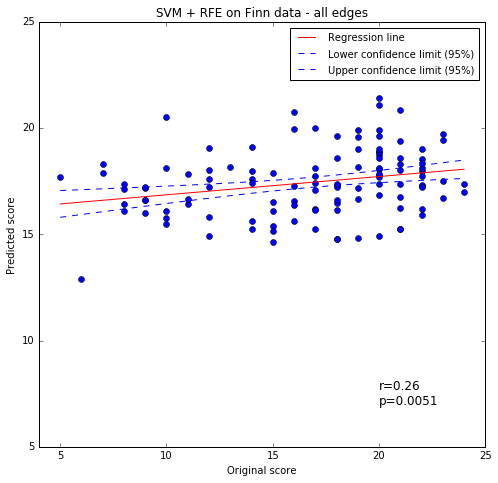

In [15]:
regression_plot(np.ravel(gF),np.ravel(preds_1),n_subj,'SVM + RFE on Finn data - all edges') 

In [16]:
results = {'svm_preds':preds_1, 'score':gF}
sio.savemat('res_svm_loo.mat', results)

### Results on extended data set 

In [ ]:
print(preds_2)

In [ ]:
results = sio.loadmat('res_svm_loo.mat')
results['res_svm_ext'] = preds_2
sio.savemat('res_svm_loo.mat')

In [ ]:
regression_plot(np.ravel(gF),np.ravel(preds_2),n_subj,'SVM + RFE on extended data - all edges') 

In [46]:
results = {'svm_preds':gF, 'score':y_test}
sio.savemat('res_svm_ext.mat', results)

### Results with improved preprocessing

In [12]:
print(np.transpose(preds_3))

[[ 15.15171034  17.2539892   17.13865886  18.0668842   15.00360564
   15.9952693   17.3993208   17.68851403  15.6673389   18.26534422
   16.61373299  19.11973955  14.83174179  19.31353699  16.26655232
   15.85649344  16.57130643  17.41108478  19.42645251  16.9847421
   18.5132378   16.26531777  20.38022805  19.95763868  14.58696912
   16.25545314  19.52976881  18.26059011  16.85814303  17.97441332
   18.84940207  17.49699075  16.58503225  18.24344004  19.79735831
   20.6670672   17.52357836  14.23588916  16.29002912  17.49152252
   15.97796064  16.92052636  15.61344486  13.66388312  16.42265193
   16.99615682  16.86601881  15.52236279  17.24859609  13.81004153
   16.30441805  15.21468001  15.22264325  17.84628346  15.59525287
   13.42727112  14.74214096  17.29788876  17.24145941  13.7608123
   15.35793275  16.79058552  18.61065493  17.62615256  16.83675588
   16.15898112  16.8831828   16.08351022  15.26712558  16.99279438
   15.29863463  16.01324126  17.34342492  16.97644843  19.436309

In [9]:
print(np.transpose(preds_4))

[[ 14.42862414  15.77699333  20.23066535  17.95264311  20.23368154
   17.45872833  17.44220936  15.22242988  16.59392002  17.69593684
   17.68288352  17.2101451   18.83614596  14.66079851  14.34607096
   15.00487379  18.2068264   18.94478805  16.86894257  16.71218547
   18.49963106  16.70218801  17.52456066  16.9026543   16.22793981
   16.05012774  19.29283392  15.41373392  14.72485309  17.18003411
   16.94953572  18.2706755   15.58752924  15.92532571  18.37436253
   19.72455061  21.0000122   17.58570739  17.27681327  17.29161291
   15.91436495  16.45690678  17.16682774  13.95527917  12.875755
   15.98922685  16.13748033  16.23871575  16.5991068   14.22319987
   15.34854603  16.54934051  17.65376834  16.84329635  15.431466
   15.23020685  16.56531822  18.01252694  17.14885476  14.97623976
   16.68642394  14.96221304  18.35792749  17.74479597  15.91235826
   16.62912275  16.38732428  15.61769537  17.07154633  16.36946747
   17.67148036  16.59850039  18.68894572  21.06900373  16.00956386

In [14]:
results = sio.loadmat('res_svm_loo.mat')
results['res_svm_improved_1'] = preds_3
sio.savemat('res_svm_loo.mat',results)

In [10]:
results = sio.loadmat('res_svm_loo.mat')
results['res_svm_improved_2'] = preds_4
sio.savemat('res_svm_loo.mat',results)

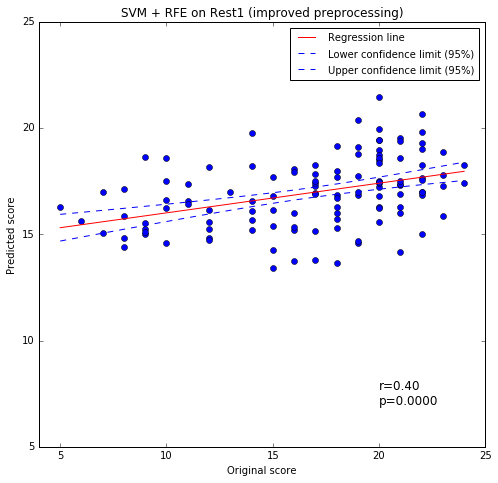

In [16]:
regression_plot(np.ravel(gF),np.ravel(preds_3),n_subj,'SVM + RFE on Rest1 (improved preprocessing)') 

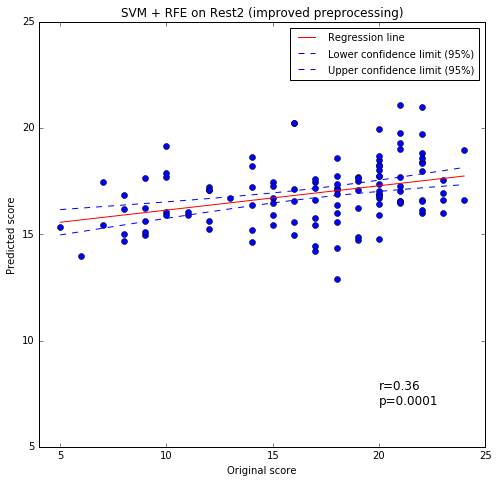

In [11]:
regression_plot(np.ravel(gF),np.ravel(preds_4),n_subj,'SVM + RFE on Rest2 (improved preprocessing)') 